# Neon Films Audience Preference Analysis

## Data Collection

In [171]:
import requests
import time
import logging

# OMDB API Key
OMDB_API_KEY = "c0c5b16c"

# configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")


# fetch movie data from omdb
def fetch_omdb_data(title):
    # user agent headers
    headers = {
        "User-Agent": (
            "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 "
            "(KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
    }
    url = f"http://www.omdbapi.com/?t={title}&apikey={OMDB_API_KEY}"
    try:
        # request data from OMDP API
        # logging.info(f"Fetching data for movie: {title}")
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        data = response.json()
        
        if data.get("Response") == "True":
            # return movie data
            movie_data = {
                "Title": data.get("Title", ""),
                "Year": data.get("Year", ""),
                "Rated": data.get("Rated", ""),
                "Runtime": data.get("Runtime", ""),
                "imdbRating": data.get("imdbRating", ""),
                "imdbVotes": data.get("imdbVotes", ""),
                "BoxOffice": data.get("BoxOffice", ""),
                "Released": data.get("Released", ""),
                "Genre": data.get("Genre", ""),
                "Director": data.get("Director", ""),
                "Writer": data.get("Writer", ""),
                "Actors": data.get("Actors", ""),
                "Plot": data.get("Plot", ""),
                "Language": data.get("Language", ""),
                "Country": data.get("Country", ""),
                "Awards": data.get("Awards", ""),
                "Poster": data.get("Poster", ""),
                "Metascore": data.get("Metascore", ""),
                "Ratings": data.get("Ratings", "")
            }
            # logging.info(f"Successfully fetched data for movie: {title}")
            return movie_data
        # error fetching data
        error_message = data.get("Error", "Unknown error occurred")
        logging.error(f"Failed to fetch data for movie: {title}. Error: {error_message}")
        return {"error": error_message}
    
    # error with api request
    except requests.RequestException as e:
        logging.error(f"Request failed for movie: {title}. Error: {str(e)}")
        return {"error": f"Request failed: {str(e)}"}

In [172]:
from trendspy import Trends
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta

# initialize trendsPy with 10s request delay
tr = Trends(request_delay=10.0)

# fetch movie data from google trends
def fetch_googletrends_data(movie):
    # extract movie title and release date
    # remove ':' character to avoid google trends error
    title = movie["Title"].replace(":", "")
    release_date = movie["Released"]
    
    # convert release date to datetime format
    release_datetime = datetime.strptime(release_date, "%d %b %Y")
    # get date for one year later
    one_year_later = release_datetime + relativedelta(years=1)
    one_year_later_strftime = one_year_later.strftime("%Y-%m-%d")

    # timeframe string
    timeframe = f'{one_year_later_strftime} 1-y'
    
    try:
        # get number of movie searches
        # logging.info(f"Fetching Google Trends data for movie: {title}")
        interest_data = tr.interest_over_time(title, timeframe=timeframe)
        
        if not interest_data.empty:
            # get total number of searches in timeframe
            total_searches = interest_data[title].sum()
            # logging.info(f"Successfully fetched Google Trends data for movie: {title}.")
            return total_searches
        
        else:
            # error fetching data from api
            logging.warning(f"No data found for movie: {title}")
            return None
    # error with api request
    except Exception as e:
        logging.error(f"Error fetching Google Trends data for movie: {title}. Error: {str(e)}")
        return None

In [173]:
import pandas as pd
from tqdm import tqdm
import time

# load movie list
movies_path = "data/movies.xlsx"
movies_list = pd.read_excel(movies_path)

# store fetched data in cache for further use
omdb_cache = {}
googletrends_cache = {}

In [174]:
# store data for each movie
omdb_data_list = []
# fetch omdb data for movie list
for row_index, row in tqdm(movies_list.iterrows(), total=len(movies_list), desc="Fetching OMDB Data"):
    # extract movie title and id
    title = row["title"]
    movie_id = row_index
    
    # check if data has already been fetched
    if movie_id in omdb_cache:
        # fetch data from cache
        # logging.info(f"Using cached data for movie: {title}")
        omdb_data = omdb_cache[movie_id]
    else:
        # fetch data from api
        # logging.info(f"Fetching data for movie: {title}")
        omdb_data = fetch_omdb_data(title)
        # add delay to avoid api rate limits 
        time.sleep(1)
    if omdb_data:
        omdb_data["ID"] = movie_id
        # store fetched data in cache
        omdb_cache[movie_id] = omdb_data
        # store data in list
        omdb_data_list.append(omdb_data)
        # logging.info(f"Successfully processed data for movie: {title}")
    else:
        logging.warning(f"No data found for movie: {title}")
        continue
omdb_df = pd.DataFrame(omdb_data_list)

Fetching OMDB Data: 100%|█████████████████████| 150/150 [03:11<00:00,  1.28s/it]


In [ ]:
# filter data to movies released after 2006 for google trends
omdb_df_after_2006 = omdb_df[omdb_df["Year"].astype(int) >= 2006]

# store data for each movie
googletrends_data_list = []

# fetch googletrends data for movie list
for row_index, row in tqdm(omdb_df_after_2006.iterrows(), total=len(omdb_df_after_2006), desc="Fetching Google Trends Data"):
    # extract movie features
    title = row["Title"]
    release_date = row["Released"]
    movie_id = row["ID"]
    # check if data has already been fetched
    if movie_id in googletrends_cache:
        # fetch data from cache
        # logging.info(f"Using cached data for movie: {title}")
        googletrends_data = googletrends_cache[movie_id]
    else:
        # fetch data from api
        # logging.info(f"Fetching data for movie: {title}")
        googletrends_data = fetch_googletrends_data(row)
    if googletrends_data:
        # store fetched data in cache
        googletrends_cache[movie_id] = googletrends_data
        # store data in list
        googletrends_data_list.append({"ID": movie_id, "GoogleSearches": googletrends_data})
    else:
        logging.warning(f"No data found for movie: {title}")
        continue     
googletrends_df = pd.DataFrame(googletrends_data_list)

Fetching Google Trends Data:  23%|███▎          | 22/94 [03:40<12:00, 10.01s/it]

In [48]:
# merge and save data to csv file
merged_df = omdb_df.merge(googletrends_df, on="ID", how="left")
merged_df.fillna("N/A", inplace=True)
merged_df.to_csv("data/merged_movies.csv", index=False)

## Data Cleaning and Preperation

In [103]:
# create new dataframe for movies in each genre
df_genre_exploded = merged_df.assign(Genre=merged_df['Genre'].str.split(',')).explode('Genre')
genre_df = df_genre_exploded.groupby('Genre')['ID'].apply(list).reset_index()
genre_df.to_csv("data/movies_bygenre.csv", index=False)

In [120]:
import re
# fix datatypes and create new features
def transform_data(df):
    df = df.replace('N/A', pd.NA)
    
    df["Title"] = df["Title"].str.title()
    df["Year"] = pd.to_numeric(df["Year"], errors='coerce')
    
    df["Rated"] = df["Rated"].fillna('Not Rated')
    rating_map = {
    'R': 'R', 'NC-17': 'R', 'TV-MA': 'R',
    'PG': 'PG', 'PG-13': 'PG', 'TV-PG': 'PG', 'TV-14': 'PG',
    'TV-G': 'G', 'Approved': 'G', 'G': 'G',
    'Not Rated': 'Not Rated', 'Unrated': 'Not Rated'}
    df["Rated"] = df["Rated"].map(rating_map)
    
    df["Runtime"] = df["Runtime"].fillna("")
    df["Runtime"] = df["Runtime"].str.replace(" min", "")
    df["Runtime"] = pd.to_numeric(df["Runtime"], errors='coerce')
    
    df["imdbRating"] = pd.to_numeric(df["imdbRating"], errors='coerce')
    df["imdbVotes"] = pd.to_numeric(df["imdbVotes"].str.replace(',', ''), errors='coerce')
    df["BoxOffice"] = pd.to_numeric(df["BoxOffice"].str.replace("$", "").str.replace(',', ''), errors='coerce')
    df["Released"] = pd.to_datetime(df["Released"], format="%d %b %Y", errors='coerce')
    
    df = df.drop(columns=["Genre", "Director", "Writer", "Actors", "Plot", "Language", "Country"], axis=1)
    
    df["Awards"] = df["Awards"].apply(
        lambda x: sum(map(int, re.findall(r'\d+', x))) if isinstance(x, str) and re.search(r'\d', x) else pd.NA
    )
    df["Awards"] = pd.to_numeric(df["Awards"], errors='coerce')
    
    df = df.drop("Poster", axis=1)
    
    df["Metascore"] = pd.to_numeric(df["Metascore"], errors='coerce')
    df["RTScore"] = df['Ratings'].apply(lambda x: next((item['Value'] for item in x if item['Source'] == 'Rotten Tomatoes'), pd.NA))
    df["RTScore"] = pd.to_numeric(df["RTScore"].str.replace('%', ''), errors='coerce')
    
    df = df.drop("Ratings", axis=1)
    
    df["GoogleSearches"] = pd.to_numeric(df["GoogleSearches"], errors='coerce')
    df["Month"] = df["Released"].dt.month
    
    df["AvgRating"] = df.apply(
    lambda row: np.nanmean([row["imdbRating"] * 10, row['Metascore'], row['RTScore']]), axis=1)

    return df

In [121]:
movies_df = transform_data(merged_df)
movies_df.to_csv("data/transformed_movies.csv", index=False)

## Data Visualization

In [123]:
# filter movies to movies released after 2006 with available box office earnings
movies_df_filtered = movies_df[(movies_df["Year"] >= 2006) & (movies_df["BoxOffice"].notna())]

In [124]:
movies_df_filtered.describe()

,Year,Runtime,imdbRating,imdbVotes,BoxOffice,Released,Awards,Metascore,ID,GoogleSearches,RTScore,Month,AvgRating
count,62.000000,62.000000,62.000000,6.200000e+01,6.200000e+01,62,58.000000,60.000000,62.000000,61.000000,62.000000,62.000000,62.000000
mean,2012.483871,107.274194,6.408065,1.394344e+05,4.378076e+07,2013-03-05 21:17:25.161290240,38.637931,56.650000,71.758065,1539.508197,55.516129,6.838710,58.481183
min,2006.000000,83.000000,3.900000,1.331800e+04,4.631000e+03,2006-03-10 00:00:00,1.000000,22.000000,0.000000,100.000000,0.000000,1.000000,25.000000
25%,2009.000000,93.250000,6.000000,2.846875e+04,3.034248e+06,2009-03-07 18:00:00,4.250000,43.750000,40.250000,844.000000,28.750000,3.250000,42.166667
50%,2012.000000,102.500000,6.400000,7.915950e+04,2.099649e+07,2012-10-28 12:00:00,8.000000,54.000000,72.500000,1217.000000,56.500000,7.000000,59.500000
75%,2016.000000,119.000000,6.900000,1.705030e+05,6.284385e+07,2016-09-05 12:00:00,40.250000,71.250000,110.750000,1979.000000,82.750000,10.000000,74.583333
max,2020.000000,174.000000,8.500000,1.460913e+06,2.199641e+08,2020-01-24 00:00:00,307.000000,89.000000,147.000000,4666.000000,96.000000,12.000000,87.000000
std,4.253222,17.707245,0.843548,2.142656e+05,5.283493e+07,NaN,67.320313,18.669131,42.292380,990.050548,28.578188,3.644864,17.798613


In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

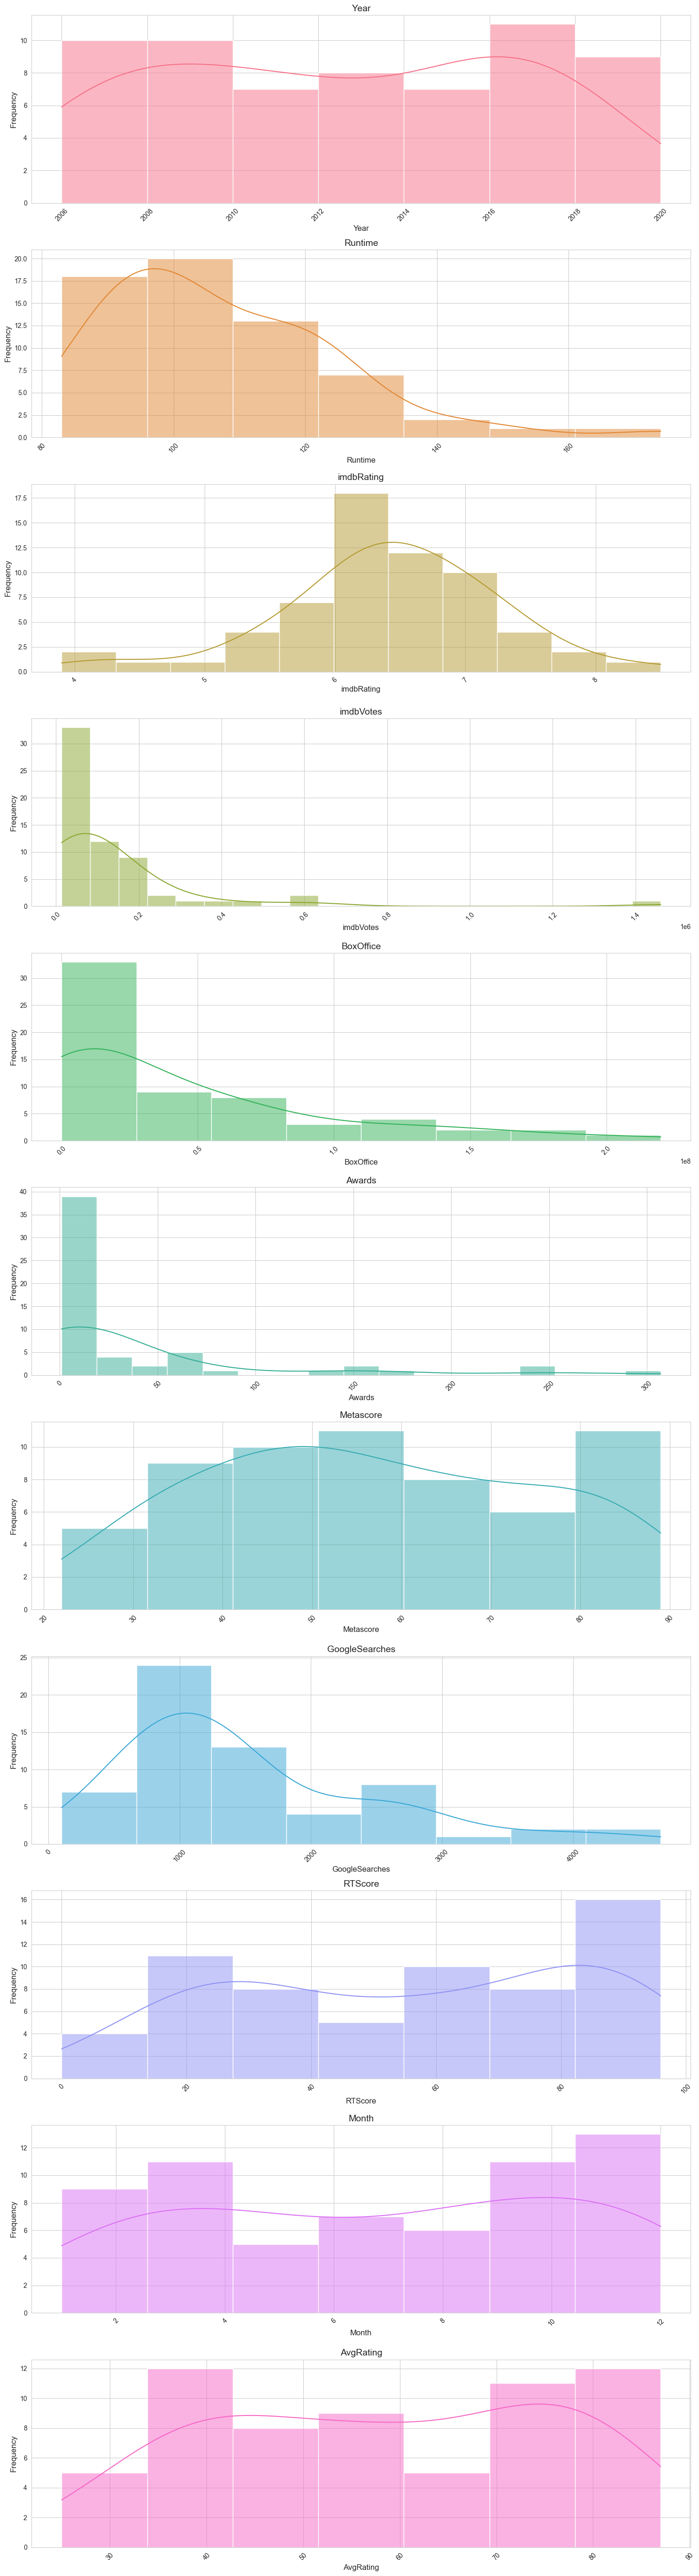

In [128]:
def plot_histograms(df, features):
    sns.set_style("whitegrid")
    palette = sns.color_palette("husl", len(features))

    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(15, 5 * len(features)))
    for ax, col, color in zip(axes, features, palette):
        sns.histplot(df[col], kde=True, ax=ax, color=color)
        ax.set_title(col, fontsize=14)
        ax.set_xlabel(col, fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)
        ax.tick_params(axis='x', rotation=45)
    plt.tight_layout()
    plt.show()
    
numerical_columns = ["imdbRating", "Bo", "AvgRating"]
plot_histograms(movies_df_filtered, numerical_columns)

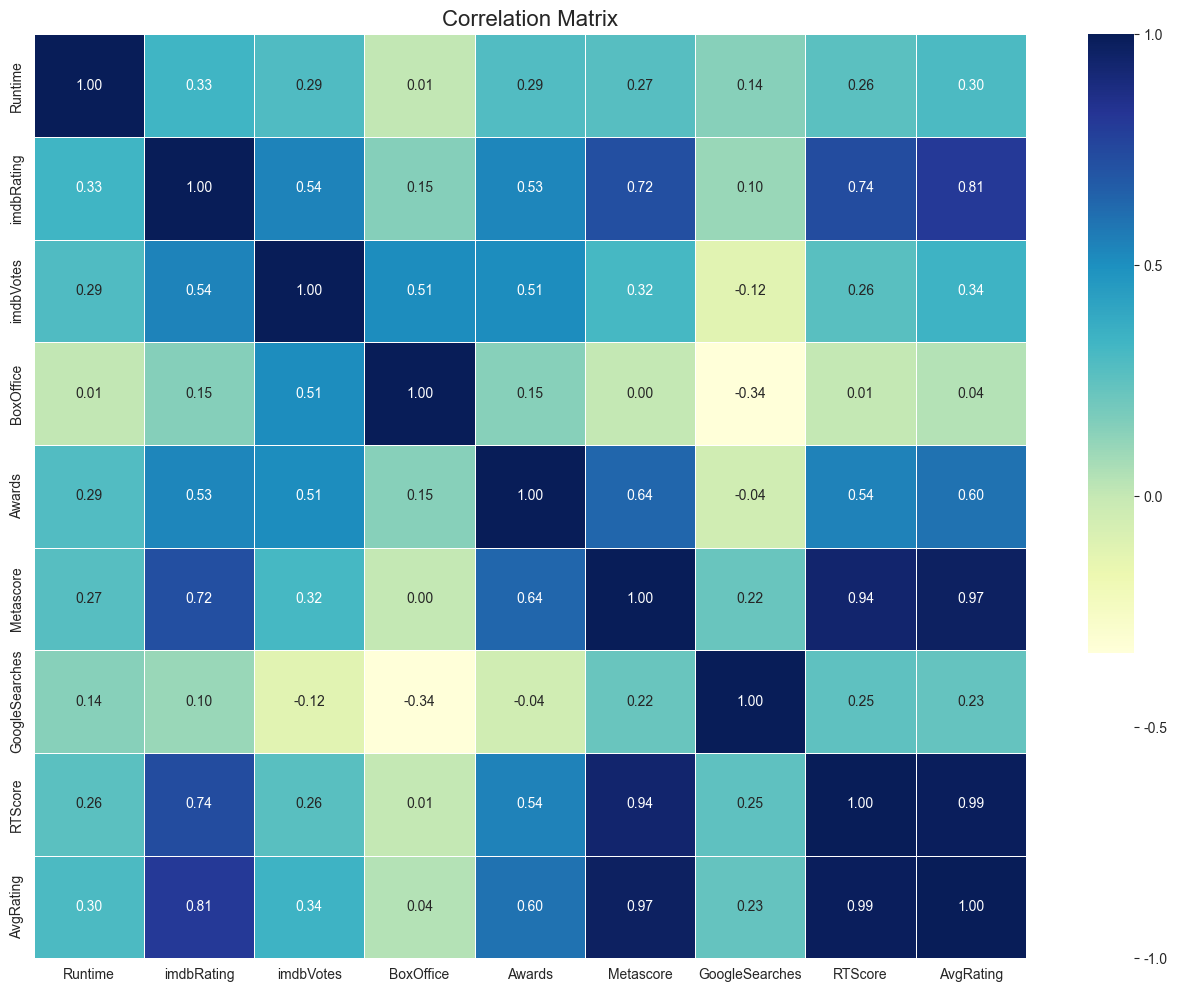

In [130]:
corr_features = ["Runtime", "imdbRating", "imdbVotes", "BoxOffice", "Awards", "Metascore", "GoogleSearches", "RTScore", "AvgRating"]

def plot_heatmap(df, features):
    plt.figure(figsize=(16, 12))

    heatmap = sns.heatmap(
        df[features].corr(),
        annot=True,
        cmap="YlGnBu",
        fmt=".2f",
        linewidths=0.5,
        annot_kws={"size": 10}
    )

    plt.title("Correlation Matrix", fontsize=16)

    colorbar = heatmap.collections[0].colorbar
    colorbar.set_ticks([-1, -0.5, 0, 0.5, 1])
    colorbar.set_ticklabels(['-1.0', '-0.5', '0.0', '0.5', '1.0'])
    colorbar.ax.tick_params(labelsize=10)

    plt.show()
    
plot_heatmap(movies_df_filtered, corr_features)

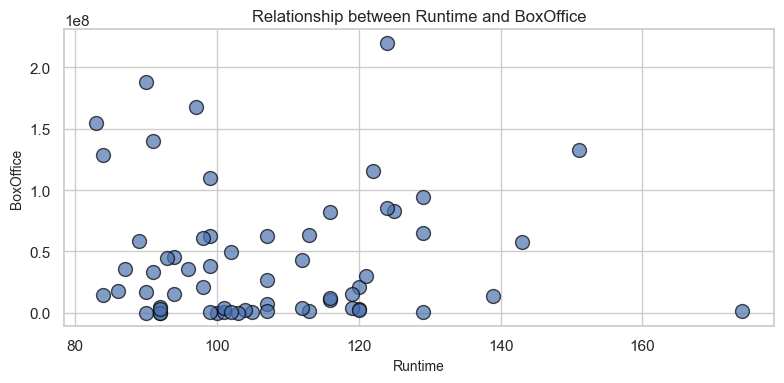

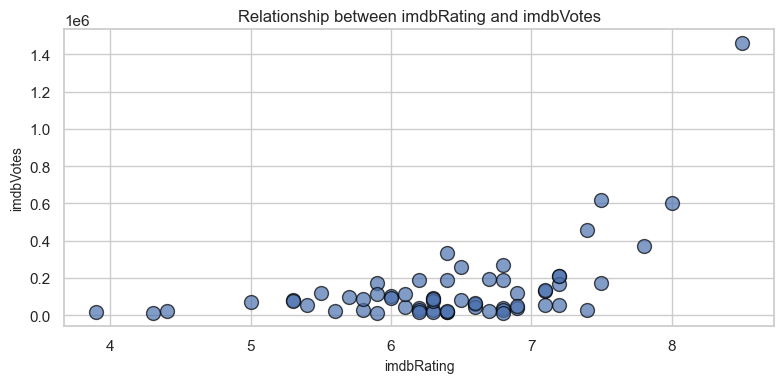

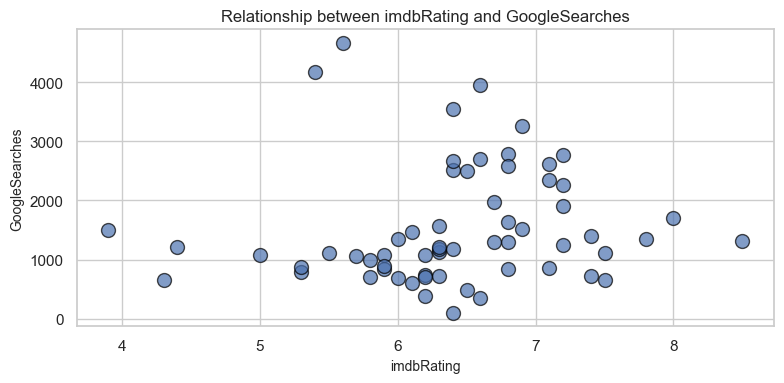

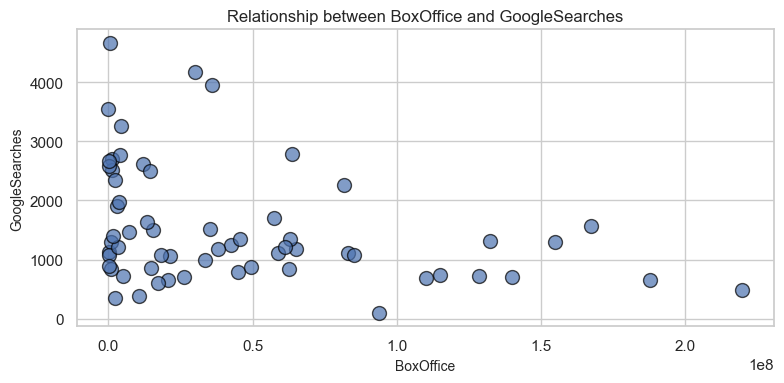

In [144]:
def plot_columns(df, col1, col2):
    sns.set(style="whitegrid")

    plt.figure(figsize=(8, 4))

    plt.scatter(df[col1], df[col2], color='b', edgecolor='black', alpha=0.7, s=100)

    plt.title(f'Relationship between {col1} and {col2}', fontsize=12)
    plt.xlabel(col1, fontsize=10)
    plt.ylabel(col2, fontsize=10)

    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
plot_columns(movies_df_filtered, "Runtime", "BoxOffice")
plot_columns(movies_df_filtered, "imdbRating", "imdbVotes")
plot_columns(movies_df_filtered, "imdbRating", "GoogleSearches")
plot_columns(movies_df_filtered, "BoxOffice", "GoogleSearches")

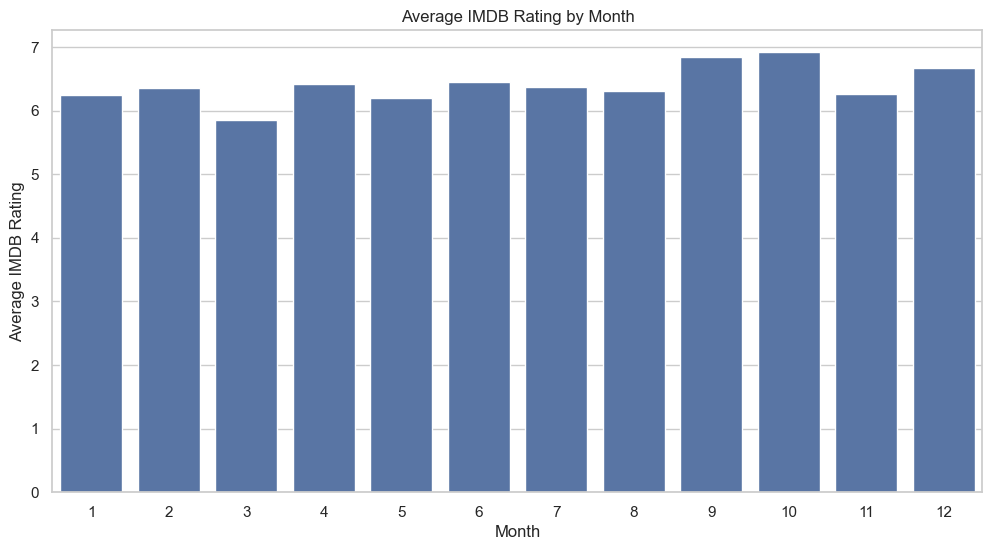

In [147]:
monthly_avg = movies_df_filtered.groupby("Month")["imdbRating"].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_avg, x="Month", y="imdbRating")
plt.title("Average IMDB Rating by Month")
plt.xlabel("Month")
plt.ylabel("Average IMDB Rating")
plt.show()

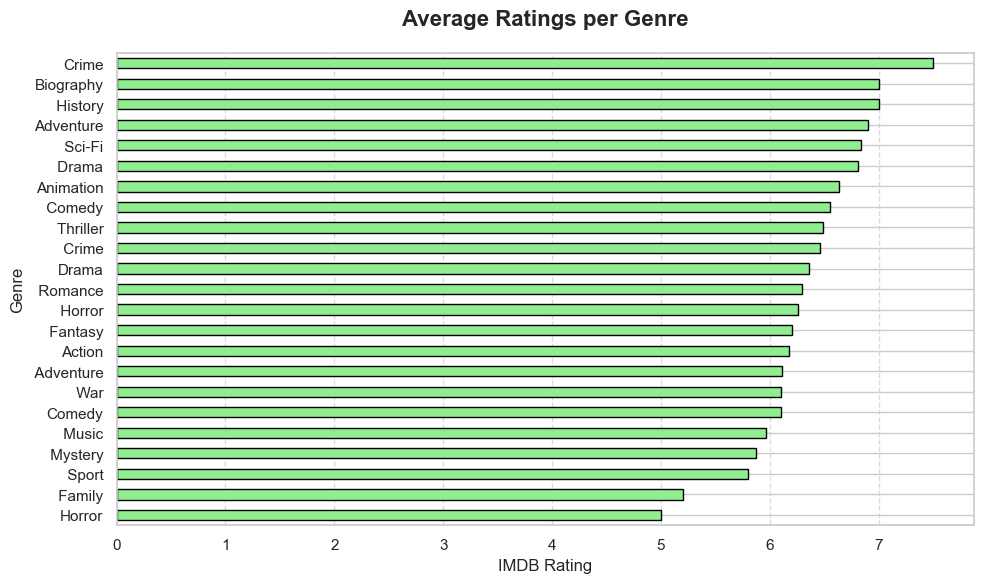

In [162]:
import pandas as pd
import matplotlib.pyplot as plt

df2_exploded = genre_df.explode('ID').reset_index(drop=True)

df3 = pd.merge(df2_exploded, movies_df_filtered[['ID', 'imdbRating']], on='ID', how='left')

df3 = df3.dropna(subset=['imdbRating'])

avg_ratings_per_genre = df3.groupby('Genre')['imdbRating'].mean()

plt.figure(figsize=(10, 6))

avg_ratings_per_genre.sort_values().plot(kind='barh', color='lightgreen', edgecolor='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.title('Average Ratings per Genre', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('IMDB Rating', fontsize=12)
plt.ylabel('Genre', fontsize=12)

plt.tight_layout()
plt.show()

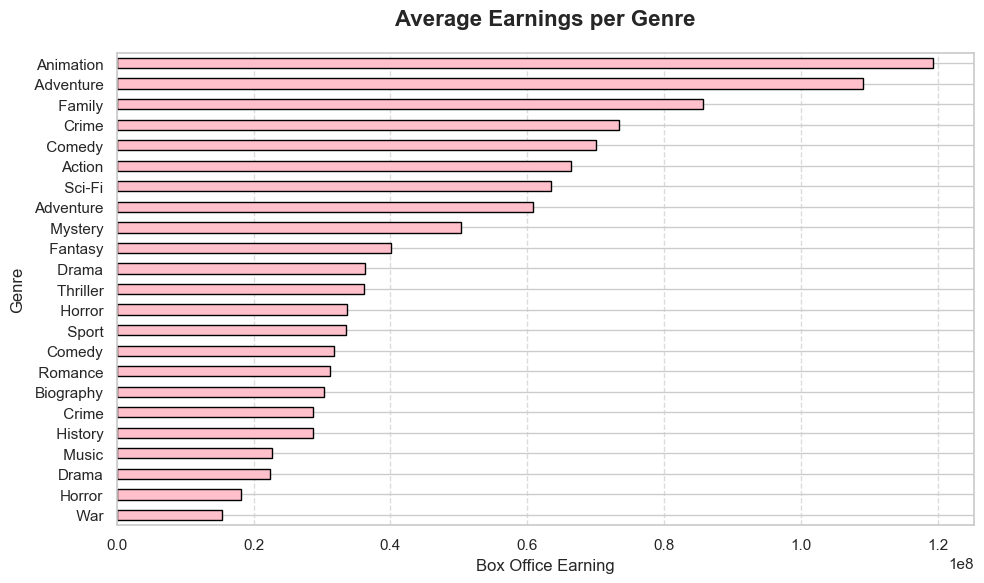

In [163]:
import pandas as pd
import matplotlib.pyplot as plt

df2_exploded = genre_df.explode('ID').reset_index(drop=True)

df3 = pd.merge(df2_exploded, movies_df_filtered[['ID', 'BoxOffice']], on='ID', how='left')

df3 = df3.dropna(subset=['BoxOffice'])

avg_ratings_per_genre = df3.groupby('Genre')['BoxOffice'].mean()

plt.figure(figsize=(10, 6))

avg_ratings_per_genre.sort_values().plot(kind='barh', color='pink', edgecolor='black')

plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.title('Average Earnings per Genre', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Box Office Earning', fontsize=12)
plt.ylabel('Genre', fontsize=12)

plt.tight_layout()
plt.show()